In [1]:
# This are just some graphical parameters to obtain the same figures that are in the paper.
library('magicaxis')
library('ggplot2')
library('latex2exp')

newpars <- list(family   = "serif", 
                cex.lab  = 1.3, 
                cex.main = 1.3, 
                cex.axis = 1.3, 
                lwd      = 1.1, 
                cex      = 1.1, 
                mgp      = c(3, 1, 0),
                oma      = c(0.5, 0.3, 0.3, 0.3),
                mfrow    = c(1,1))
# clusters galaxies
c1 <- rgb(185/255, 18/255, 40/255,1)   #b91228
# backsplash
c2 <- rgb(255/255,133/255,27/255,1)    #ff851b
# infall 
c3 <- rgb(95/255, 75/255, 139/255,1)   #5f4b8b
# recent infallers
c4 <- rgb(61/255, 153/255, 112/255,1)  #3d9970


# Example 1: Testing the ROGER package with an independent galaxy cluster (see XXXX.XXXX for more references).

In this Notebook you will reproduce figure X of XXXX.XXXX and learn how to analyze the data of 
galaxy cluster.

## Let's load the package

In [2]:
library('ROGER')

Loading required package: randomForest

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


Loading required package: caret

Loading required package: lattice

Loading required package: kernlab


Attaching package: ‘kernlab’


The following object is masked from ‘package:ggplot2’:

    alpha




[1] "Welcome to ROGER v1.0"

______________________________________________¶¶¶¶¶¶¶_______
____________________¶¶¶¶¶___________________¶¶¶¶____¶¶______
___________________¶¶¶¶¶¶¶_________________¶¶¶_______¶¶_____
____________________¶¶¶¶¶¶________________¶¶¶________¶¶_____
____________________¶¶¶¶¶_________________¶¶________¶¶______
__________________¶¶¶¶¶¶¶_________________¶¶_______¶¶¶______
_________________¶¶¶¶¶¶¶¶¶¶_______________¶¶_____¶¶¶________
________________¶¶¶¶¶__¶¶¶¶¶¶_____________¶¶__¶¶¶¶¶_________
______________¶¶¶¶¶¶¶___¶¶¶¶¶¶¶__________¶¶¶¶¶¶¶____________
______________¶¶¶¶¶¶¶¶¶___¶¶¶¶¶¶¶¶______¶¶¶¶¶_______________
_____________¶¶¶¶__¶¶¶¶¶¶____¶¶¶¶¶¶¶¶¶¶¶¶¶¶_________________
____________¶¶¶¶¶____¶¶¶¶¶¶¶____¶¶¶¶¶¶¶¶¶¶__________________
____________¶¶¶¶_______¶¶¶¶¶¶¶¶¶_____¶¶¶____________________
____________¶¶¶¶__________¶¶¶¶¶¶¶¶¶¶¶¶¶_____________________
____________¶¶¶¶_______________¶¶¶¶¶¶¶¶_____________________
_____________¶¶¶¶¶______________________________________

## Let's load the data

In [3]:
# Let's load the ML model
data('knn') 

# You can also try svm and rf that will

In [4]:
# Let's load the testing set
data(testCluster)

In [5]:
# Let's see the structure of this data frame
str(testCluster)

'data.frame':	731 obs. of  3 variables:
 $ r         : num  0.968 2.122 1.373 2.793 1.462 ...
 $ v         : num  0.645 0.471 0.175 0.384 0.397 ...
 $ real_class: Factor w/ 4 levels "X1","X2","X3",..: 3 3 3 3 3 3 3 3 3 3 ...


In [6]:
# Let's keep only with the 'r' and 'v' columns that will be used to predict, and
# save the real classification for future comparison.

cat        <- testCluster[, c(1, 2)]
real_class <- as.factor(testCluster$real_class)

## Let's predict the classes and compare with the real ones

In [7]:
pred_prob <- get_class(cat, model = knn, type = 'prob')

In [8]:
# Let's join all the information and classify by the most probable class 
#   (this is the same as putting type = 'raw' in the get_class function)

cat        <- data.frame(cat, real_class, pred_prob)
pred_class <- vector()
for(i in 1:length(pred_prob$X1)){
    pred_class[i] = paste0('X', toString(which.max(pred_prob[i,])))
}
cat <- data.frame(cat, pred_class)

cat1 <- subset(cat, cat$pred_class == 'X1') # Predicted Cluster galaxies
cat2 <- subset(cat, cat$pred_class == 'X2') # Predicted Backsplash
cat3 <- subset(cat, cat$pred_class == 'X3') # Predicted Infallers
cat4 <- subset(cat, cat$pred_class == 'X4') # Predicted Recent Infallers

## Let's measure the performance of ROGER

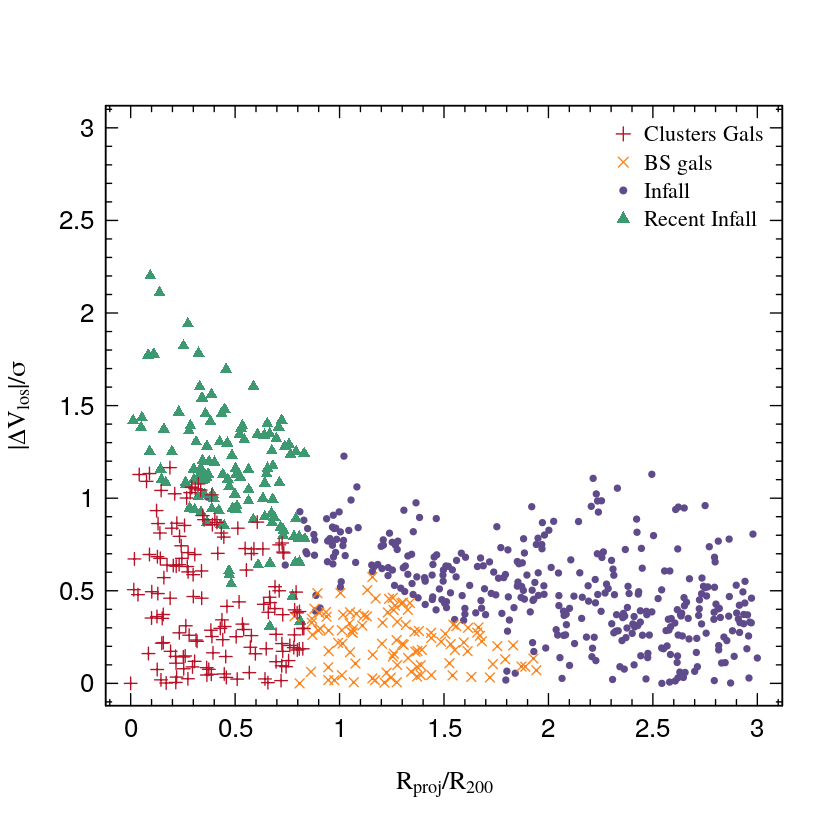

In [10]:
# Let's see the final predictions

par(newpars)
plot(cat$r, cat$v, xlab = TeX('R_{proj}/R_{200}'), ylab = TeX('|$\\Delta$V_{los}|/$\\sigma$'),
     xlim = c(0, 3), ylim = c(0, 3), cex = 0.1, axes = F)
magaxis(side=1, majorn=5, minorn=5, tcl=0.5, ratio=0.5, labels=TRUE)
magaxis(side=2, majorn=5, minorn=5, tcl=0.5, ratio=0.5, labels=TRUE,las=2)
magaxis(side=3:4, majorn=5, minorn=5, tcl=0.5, ratio=0.5, labels=FALSE)
box()
points(cat3$r, cat3$v, col = c3, pch = 20)
points(cat4$r, cat4$v, col = c4, pch = 17)
points(cat2$r, cat2$v, col = c2, pch = 4)
points(cat1$r, cat1$v, col = c1, pch = 3)
legend('topright', c('Clusters Gals', 'BS gals', 'Infall', 'Recent Infall'), col = c(c1, c2, c3, c4), pch = c(3, 4, 20, 17), bty = 'n', cex = c(1.1,1.1,1.1,1.1))

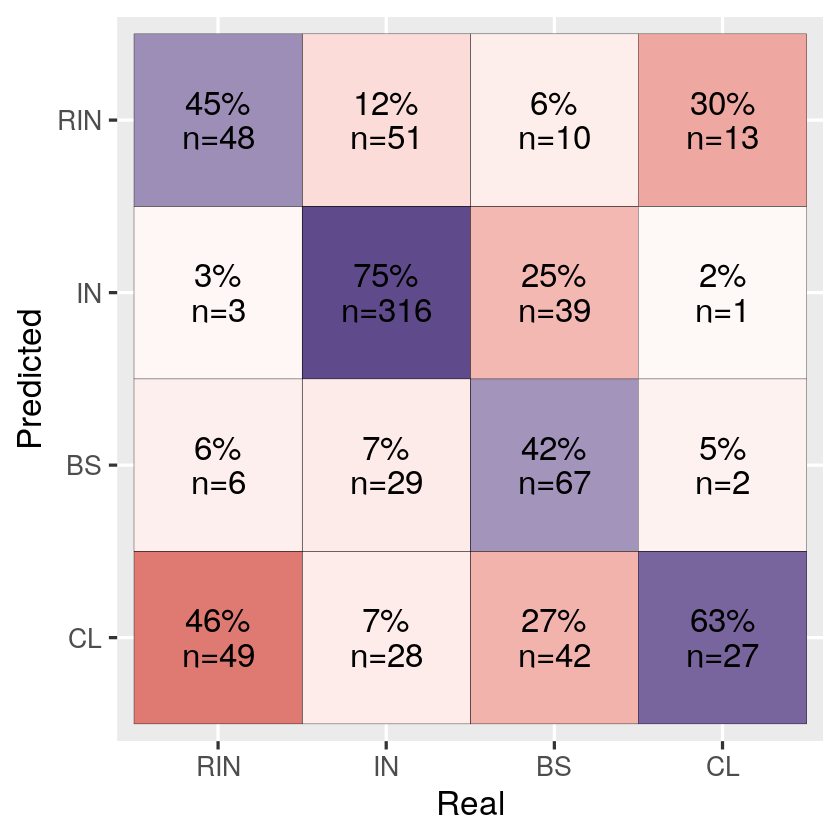

In [12]:
Real            <- cat$real_class
Predict         <- cat$pred_class
levels(Predict) <- c('CL', 'BS', 'IN', 'RIN')
levels(Real)    <- c('CL', 'BS', 'IN', 'RIN')

real_d        <- as.data.frame(table(Real))
names(real_d) <- c("Real", "RealFreq")

# Let's estimate the confusion matrix

cMatrix        <- as.data.frame(table(Real, Predict, useNA = 'ifany'))
names(cMatrix) <- c("Real", "Predicted", "Freq")

cMatrix            <- merge(cMatrix, real_d, by = c('Real', 'Real'))
cMatrix$Percent    <- cMatrix$Freq/cMatrix$RealFreq*100
cMatrix$ColorScale <- cMatrix$Percent*-1
cMatrix[which(cMatrix$Real == cMatrix$Predicted),]$ColorScale <- cMatrix[which(cMatrix$Real == cMatrix$Predicted), ]$ColorScale*-1
cMatrix$Label1 <- paste(round(cMatrix$Percent,0), "%", sep = "")
cMatrix$Label2 <- paste("n=", cMatrix$Freq, sep = "")

ggplot() +
    geom_tile(aes(x = Real, y = Predicted, fill = ColorScale), data = cMatrix, color = "black", size = 0.1) +
    labs(x = "Real", y = "Predicted") +
    theme_grey(base_size = 20) +
    geom_text(aes(x = Real, y = Predicted, label = Label1), data = cMatrix, size = 7, colour = "black", nudge_y = 0.1) +
    geom_text(aes(x = Real, y = Predicted, label = Label2), data = cMatrix, size = 7, colour = "black", nudge_y = -0.1) +
    scale_fill_gradient2(low = c1, high = c3, mid = 'white', midpoint = 0, guide = 'none') +
    xlim('RIN', 'IN', 'BS', 'CL')
